In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
applications = pd.read_csv('application_record.csv')
applications.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
credit = pd.read_csv('credit_record.csv')
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [4]:
applications.shape, credit.shape

((438557, 18), (1048575, 3))

In [5]:
len(credit['ID'].unique()), len(applications['ID'].unique())

(45985, 438510)

In [6]:
print(f'Duplicates in applications data: {applications.iloc[:,1:].duplicated().sum()}, ({np.round(100*applications.iloc[:,1:].duplicated().sum()/len(applications),1)}%)')

Duplicates in applications data: 348472, (79.5%)


In [7]:
applications=applications.drop_duplicates(subset=applications.columns[1:], keep='first')
applications.drop(['FLAG_MOBIL'], inplace=True, axis=1)

In [8]:
credit['STATUS'].nunique()
print("Application Records:")
for col in applications.columns:
    print(col ,applications[col].nunique())
print("\nCredit Records:")
for col in credit.columns:
    print(col ,credit[col].nunique())

Application Records:
ID 90085
CODE_GENDER 2
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
CNT_CHILDREN 12
AMT_INCOME_TOTAL 866
NAME_INCOME_TYPE 5
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 5
NAME_HOUSING_TYPE 6
DAYS_BIRTH 16379
DAYS_EMPLOYED 9406
FLAG_WORK_PHONE 2
FLAG_PHONE 2
FLAG_EMAIL 2
OCCUPATION_TYPE 18
CNT_FAM_MEMBERS 13

Credit Records:
ID 45985
MONTHS_BALANCE 61
STATUS 8


In [9]:
print(applications.isna().sum())
print(credit.isna().sum())

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        27477
CNT_FAM_MEMBERS            0
dtype: int64
ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


Text(0.5, 1.0, 'Missing Data of Application records')

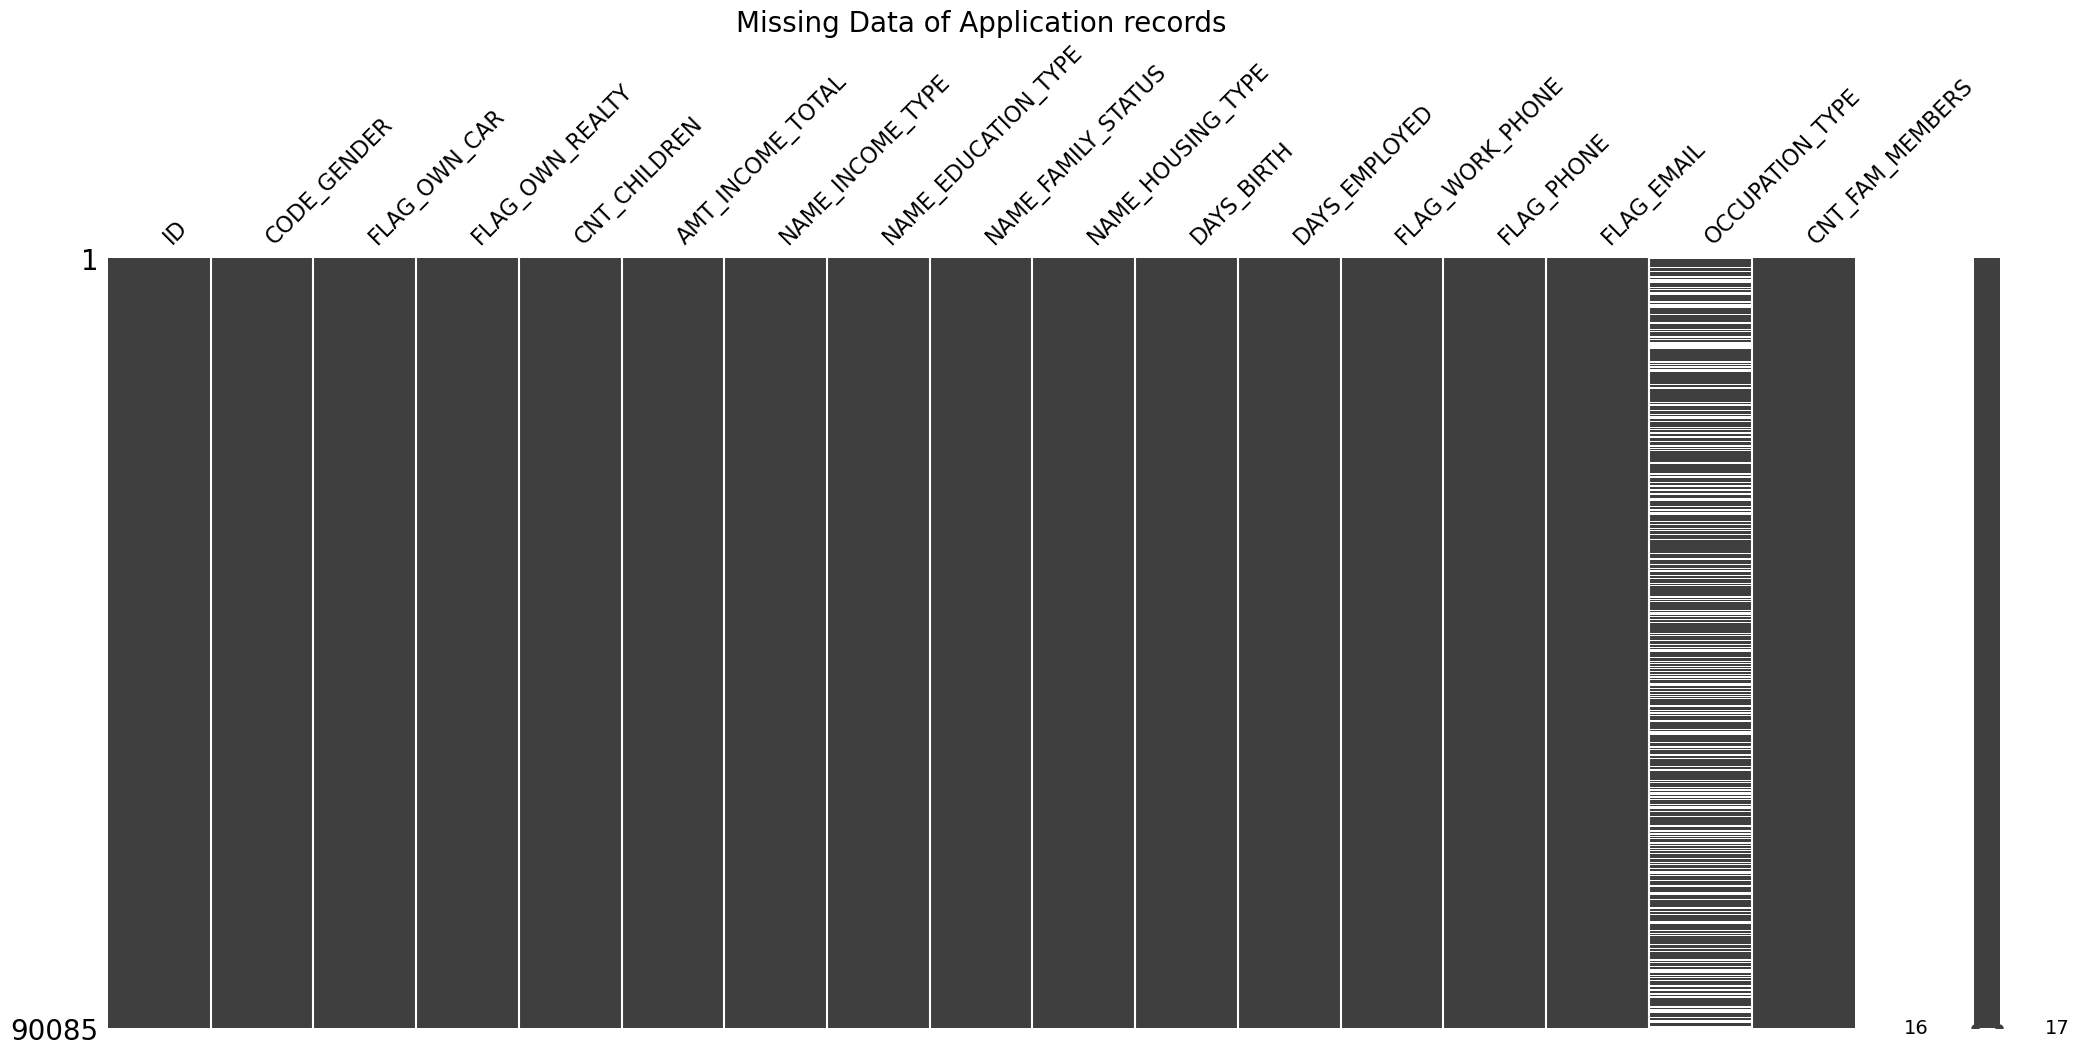

In [10]:
missing = msno.matrix(applications)
missing.set_title("Missing Data of Application records",fontsize=20)

In [11]:
applications['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)
applications['OCCUPATION_TYPE'].value_counts(dropna=False)

OCCUPATION_TYPE
Other                    27477
Laborers                 16624
Sales staff               9123
Core staff                8091
Managers                  6675
Drivers                   5860
High skill tech staff     3357
Accountants               3034
Medicine staff            2484
Cooking staff             1764
Security staff            1740
Cleaning staff            1222
Private service staff      750
Low-skill Laborers         569
Secretaries                412
Waiters/barmen staff       393
Realty agents              218
HR staff                   167
IT staff                   125
Name: count, dtype: int64

In [12]:
credit['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

In [13]:
credit['target']=credit['STATUS']
credit['target'].replace('X', 0, inplace=True)
credit['target'].replace('C', 0, inplace=True)
credit['target']=credit['target'].astype(int)
credit.loc[credit['target']>=1,'target']=1
credit.head()

,ID,MONTHS_BALANCE,STATUS,target
0,5001711,0,X,0
1,5001711,-1,0,0
2,5001711,-2,0,0
3,5001711,-3,0,0
4,5001712,0,C,0


In [14]:
df=pd.DataFrame(credit.groupby(['ID'])['target'].agg(max)).reset_index()
df.head()

,ID,target
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0


In [15]:
new_df=pd.merge(applications, df, how='inner', on=['ID'])
new_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Other,2.0,1
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,0
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,Other,1.0,0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,Accountants,2.0,0


In [16]:
start_df=pd.DataFrame(credit.groupby(['ID'])['MONTHS_BALANCE'].agg(min)).reset_index()
start_df.rename(columns={'MONTHS_BALANCE':'ACCOUNT_LENGTH'}, inplace=True)
start_df['ACCOUNT_LENGTH']=-start_df['ACCOUNT_LENGTH']
start_df.head()

,ID,ACCOUNT_LENGTH
0,5001711,3
1,5001712,18
2,5001713,21
3,5001714,14
4,5001715,59


In [17]:
new_df=pd.merge(new_df, start_df, how='inner', on=['ID'])
new_df['AGE_YEARS']=round(-new_df['DAYS_BIRTH']/365,0)
new_df.drop(["DAYS_BIRTH"],axis=1,inplace=True)
new_df['UNEMPLOYED']=0
new_df.loc[-new_df['DAYS_EMPLOYED']<0,'UNEMPLOYED']=1
new_df['YEARS_EMPLOYED']=round(-new_df['DAYS_EMPLOYED']/365)
new_df.loc[new_df['YEARS_EMPLOYED']<0,'YEARS_EMPLOYED']=0
new_df.drop('DAYS_EMPLOYED', axis=1, inplace=True)
new_df = new_df.rename(columns={'CODE_GENDER': 'Gender', 'FLAG_OWN_CAR': 'Own_car',
                                'FLAG_OWN_REALTY':'Own_property','CNT_CHILDREN':'Num_children',
                                'AMT_INCOME_TOTAL':'Total_income','NAME_INCOME_TYPE':'Income_type',
                                'NAME_EDUCATION_TYPE':'Education_type','NAME_FAMILY_STATUS':'Family_status',
                                'NAME_HOUSING_TYPE':'Housing_type','FLAG_WORK_PHONE':'Work_phone',
                                'FLAG_PHONE':'Phone','FLAG_EMAIL':'Email','OCCUPATION_TYPE':'Occupation_type',
                                'CNT_FAM_MEMBERS':'Num_family','target':'Target','ACCOUNT_LENGTH':'Account_length',
                                'AGE_YEARS':'Age','UNEMPLOYED':'Unemployed','YEARS_EMPLOYED':'Years_employed'})

In [18]:
new_df.head()

,ID,Gender,Own_car,Own_property,Num_children,Total_income,Income_type,Education_type,Family_status,Housing_type,Work_phone,Phone,Email,Occupation_type,Num_family,Target,Account_length,Age,Unemployed,Years_employed
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Other,2.0,1,15,33.0,0,12.0
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,0,29,59.0,0,3.0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,0,4,52.0,0,8.0
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,Other,1.0,0,20,62.0,1,0.0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2.0,0,5,46.0,0,2.0


<Figure size 1000x1000 with 0 Axes>

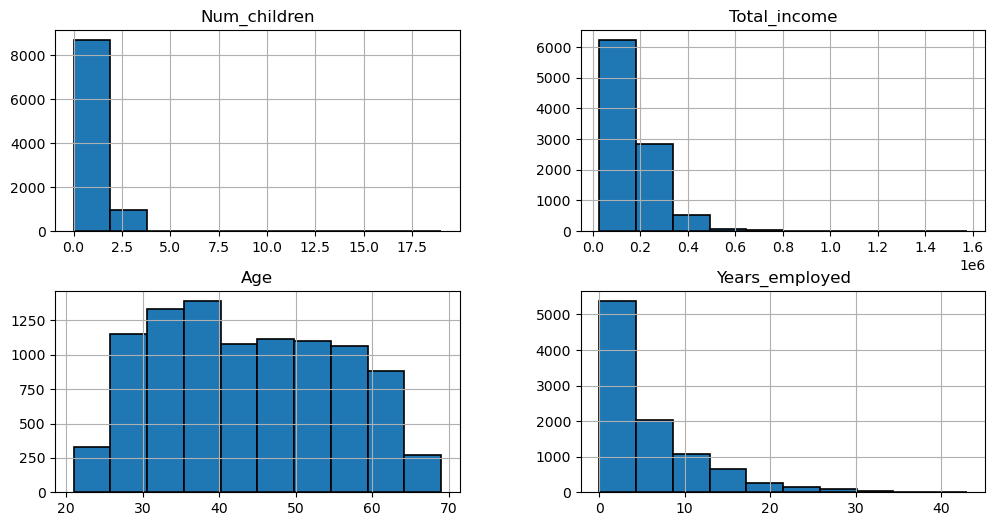

In [19]:
plt.figure(figsize=(10,10))
cols_to_plot = ["Num_children","Total_income","Age","Years_employed"]
new_df[cols_to_plot].hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,6)

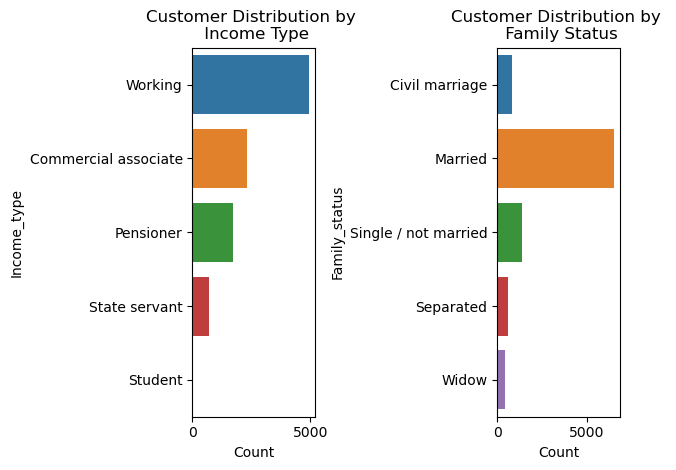

In [20]:
ig, axes = plt.subplots(1,2)
g1=sns.countplot(y=new_df.Income_type,linewidth=1.2, ax=axes[0])
g1.set_title("Customer Distribution by \n Income Type")
g1.set_xlabel("Count")
g2=sns.countplot(y=new_df.Family_status,linewidth=1.2, ax=axes[1])
g2.set_title("Customer Distribution by \n Family Status")
g2.set_xlabel("Count")
fig.set_size_inches(14,5)
plt.tight_layout()
plt.show()

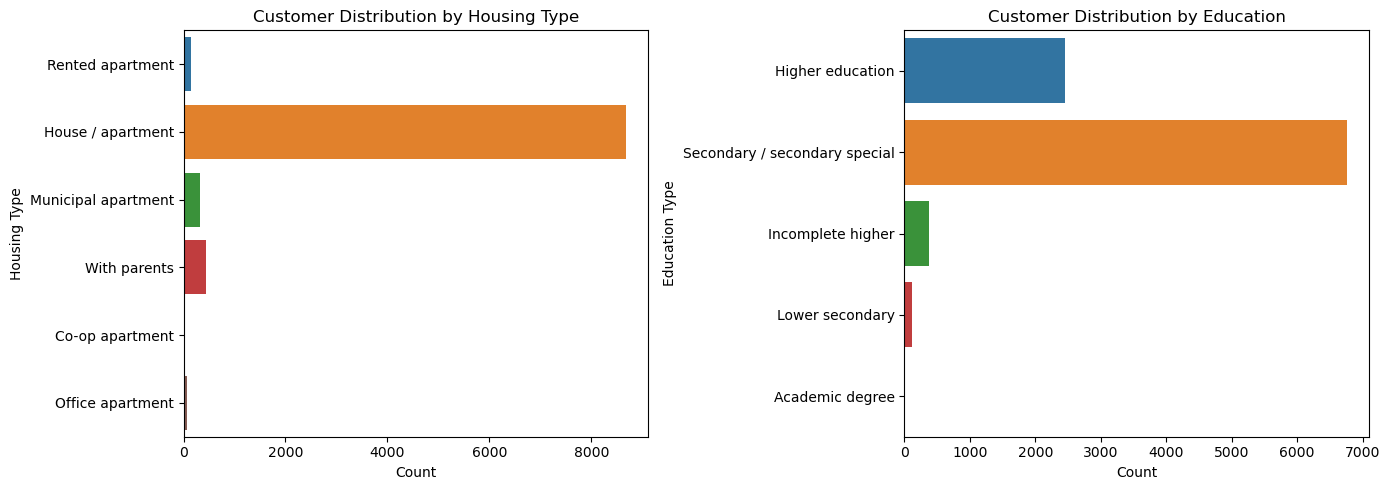

In [21]:
fig, axes = plt.subplots(1,2)
g1= sns.countplot(y=new_df.Housing_type,linewidth=1.2, ax=axes[0])
g1.set_title("Customer Distribution by Housing Type")
g1.set_xlabel("Count")
g1.set_ylabel("Housing Type")
g2= sns.countplot(y=new_df.Education_type, ax=axes[1])
g2.set_title("Customer Distribution by Education")
g2.set_xlabel("Count")
g2.set_ylabel("Education Type")
fig.set_size_inches(14,5)
plt.tight_layout()
plt.show()

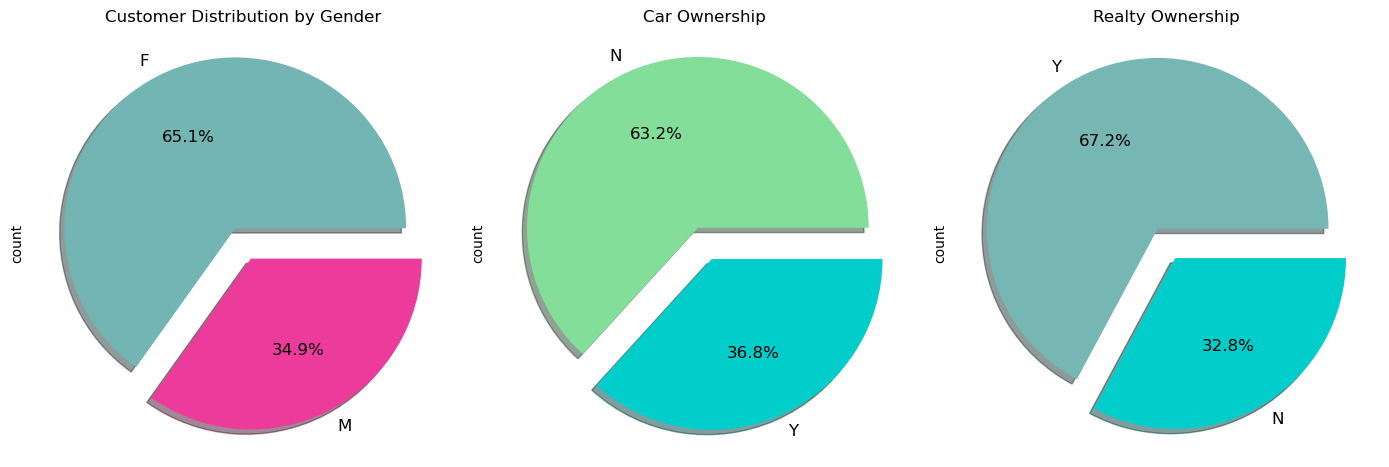

In [22]:
fig, axes = plt.subplots(1,3)
g1= new_df['Gender'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True, colors=["#73B5B3","#EC3B9A"],textprops = {'fontsize':12}, ax=axes[0])
g1.set_title("Customer Distribution by Gender")
g2= new_df['Own_car'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=["#82DE99","#01CECB"],textprops = {'fontsize':12}, ax=axes[1])
g2.set_title("Car Ownership")
g3= new_df['Own_property'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=["#76B6B3","#01CECB"],textprops = {'fontsize':12}, ax=axes[2])
g3.set_title("Realty Ownership")
fig.set_size_inches(14,5)
plt.tight_layout()
plt.show()

In [23]:
object_columns = new_df.columns[new_df.dtypes =='object'].tolist()
unique_counts = pd.DataFrame.from_records([(col, new_df[object_columns][col].nunique()) for col in new_df[object_columns].columns],columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
0,Gender,2
1,Own_car,2
2,Own_property,2
3,Income_type,5
4,Education_type,5
5,Family_status,5
6,Housing_type,6
7,Occupation_type,19


In [24]:
new_df["Gender"] =  new_df["Gender"].replace(['F','M'],[0,1])
new_df["Own_car"] = new_df["Own_car"].replace(["Y","N"],[1,0])
new_df["Own_property"] = new_df["Own_property"].replace(["Y","N"],[1,0])
new_df["Is_Working"] = new_df["Income_type"].replace(["Working","Commercial associate","State servant","Pensioner","Student"],[1,1,1,0,0])
new_df["Marital_status"] = new_df["Family_status"].replace(["Civil marriage","Married","Single / not married", "Separated","Widow"],[1,1,0,0,0])

In [25]:
housing_type = {'House / apartment' : 'House / apartment',
                'With parents': 'With parents',
                'Municipal apartment' : 'House / apartment',
                'Rented apartment': 'House / apartment',
                'Office apartment': 'House / apartment',
                'Co-op apartment': 'House / apartment'}
new_df["Housing_type"] = new_df['Housing_type'].map(housing_type)

family_status = {'Single / not married':'Single',
                 'Separated':'Single',
                 'Widow':'Single',
                 'Civil marriage':'Married',
                 'Married':'Married'}
new_df["Family_status"] = new_df["Family_status"].map(family_status)

education_type = {'Secondary / secondary special':'secondary',
                  'Lower secondary':'secondary',
                  'Higher education':'Higher education',
                  'Incomplete higher':'Higher education',
                  'Academic degree':'Academic degree'}
new_df["Education_type"] = new_df["Education_type"].map(education_type)

income_type = {'Commercial associate':'Working',
               'State servant':'Working',
               'Working':'Working',
               'Pensioner':'Pensioner',
               'Student':'Student'}
new_df["Income_type"] = new_df["Income_type"].map(income_type)

new_df["Household_Size"] = new_df["Num_children"] + new_df["Marital_status"].apply(lambda x: 2 if x==1 else 1)
new_df.head()

,ID,Gender,Own_car,Own_property,Num_children,Total_income,Income_type,Education_type,Family_status,Housing_type,...,Occupation_type,Num_family,Target,Account_length,Age,Unemployed,Years_employed,Is_Working,Marital_status,Household_Size
0,5008804,1,1,1,0,427500.0,Working,Higher education,Married,House / apartment,...,Other,2.0,1,15,33.0,0,12.0,1,1,2
1,5008806,1,1,1,0,112500.0,Working,secondary,Married,House / apartment,...,Security staff,2.0,0,29,59.0,0,3.0,1,1,2
2,5008808,0,0,1,0,270000.0,Working,secondary,Single,House / apartment,...,Sales staff,1.0,0,4,52.0,0,8.0,1,0,1
3,5008812,0,0,1,0,283500.0,Pensioner,Higher education,Single,House / apartment,...,Other,1.0,0,20,62.0,1,0.0,0,0,1
4,5008815,1,1,1,0,270000.0,Working,Higher education,Married,House / apartment,...,Accountants,2.0,0,5,46.0,0,2.0,1,1,2


<Axes: >

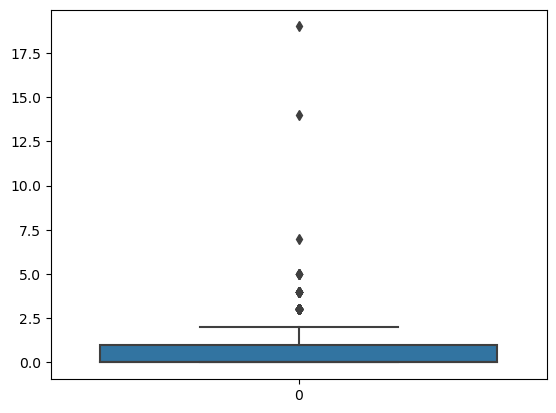

In [26]:
sns.boxplot(new_df['Num_children'])

In [27]:
high_bound = new_df['Num_children'].quantile(0.999)
print('high_bound :', high_bound)
low_bound = new_df['Num_children'].quantile(0.001)
print('low_bound :', low_bound)
new_df = new_df[(new_df['Num_children']>=low_bound) & (new_df['Num_children']<=high_bound)]

high_bound : 4.0
low_bound : 0.0


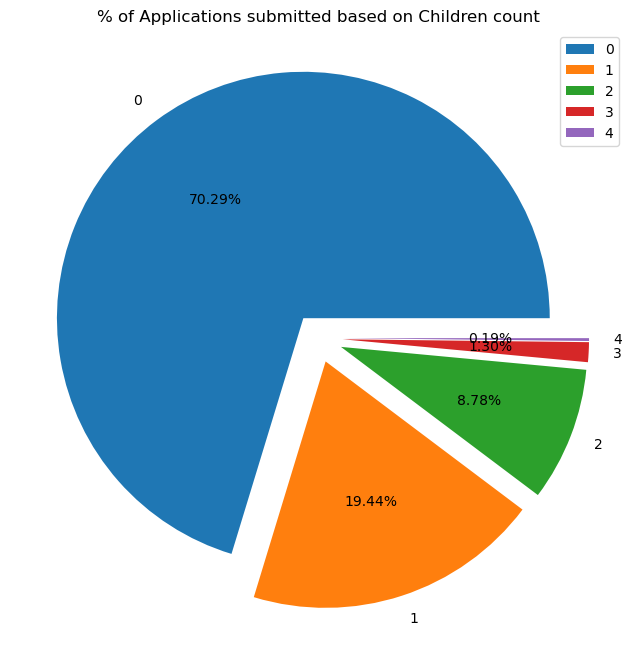

In [28]:
plt.figure(figsize = (8,8))
plt.pie(new_df['Num_children'].value_counts(), labels=new_df['Num_children'].value_counts().index,explode = [0.1,0.1,0.1,0.1,0.1],autopct='%1.2f%%')
plt.title('% of Applications submitted based on Children count')
plt.legend()
plt.show()

In [29]:
new_df = new_df.loc[:,['ID', 'Gender', 'Own_car', 'Own_property', 'Num_children',
                       'Total_income', 'Income_type', 'Education_type', 'Family_status',
                       'Housing_type', 'Work_phone', 'Phone', 'Email', 'Occupation_type',
                       'Num_family','Account_length', 'Age', 'Unemployed',
                       'Years_employed', 'Is_Working', 'Marital_status', 'Household_Size','Target']]

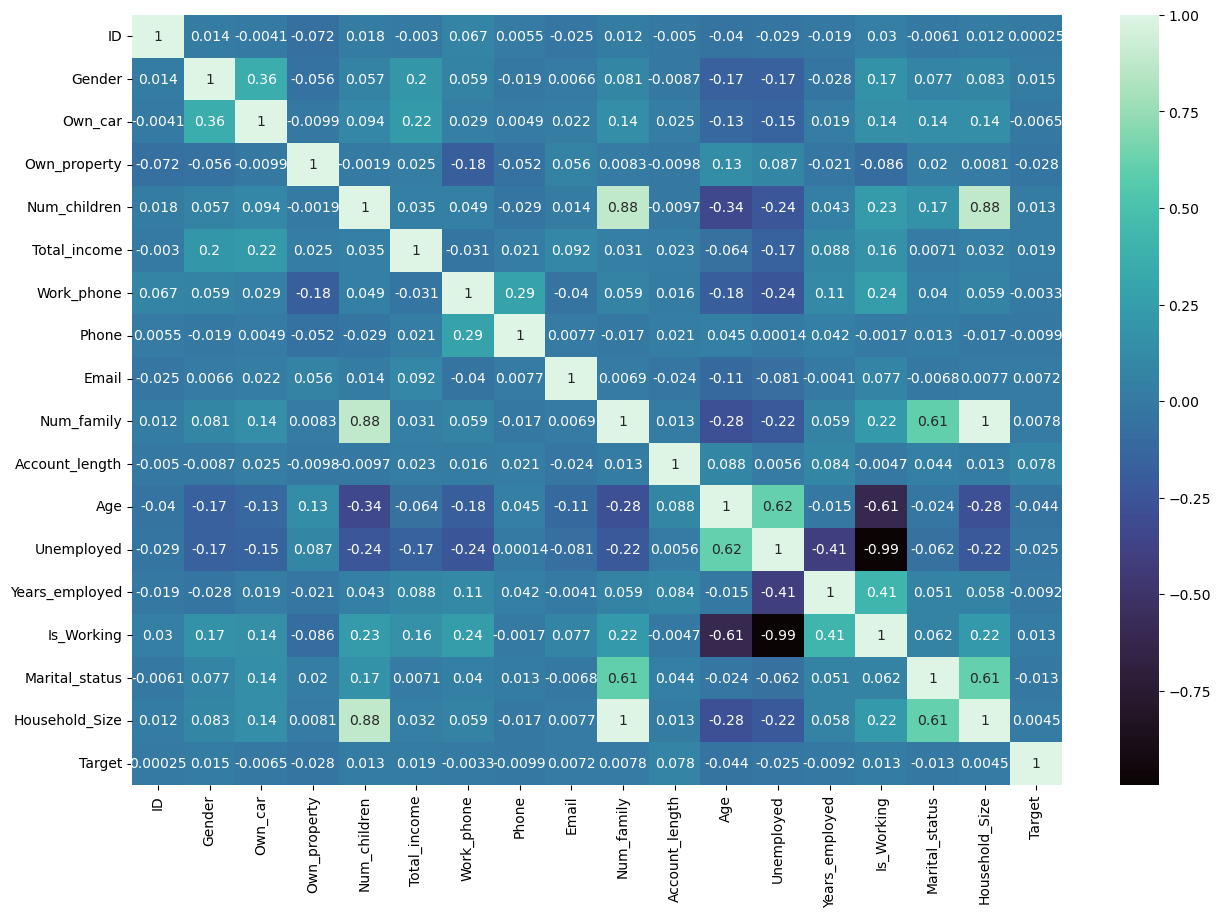

In [30]:
plt.figure(figsize=(15, 10))
corr=new_df.select_dtypes(include='number').corr()
sns.heatmap(corr,annot=True, cmap='mako')
plt.show();

In [31]:
new_df.drop('Num_family', axis=1, inplace=True)
new_df.drop(["ID"],axis=1,inplace=True)
new_df.drop('Num_children', axis=1, inplace=True)
new_df.drop(["Email"],axis=1,inplace=True)
new_df.drop('Is_Working', axis=1, inplace=True)
new_df.drop(["Phone"],axis=1,inplace=True)
new_df.drop(["Work_phone"],axis=1,inplace=True)
new_df.drop(["Occupation_type"],axis=1,inplace=True)
new_df.drop(["Family_status"],axis=1,inplace=True)
new_df.drop(["Account_length"],axis=1,inplace=True)

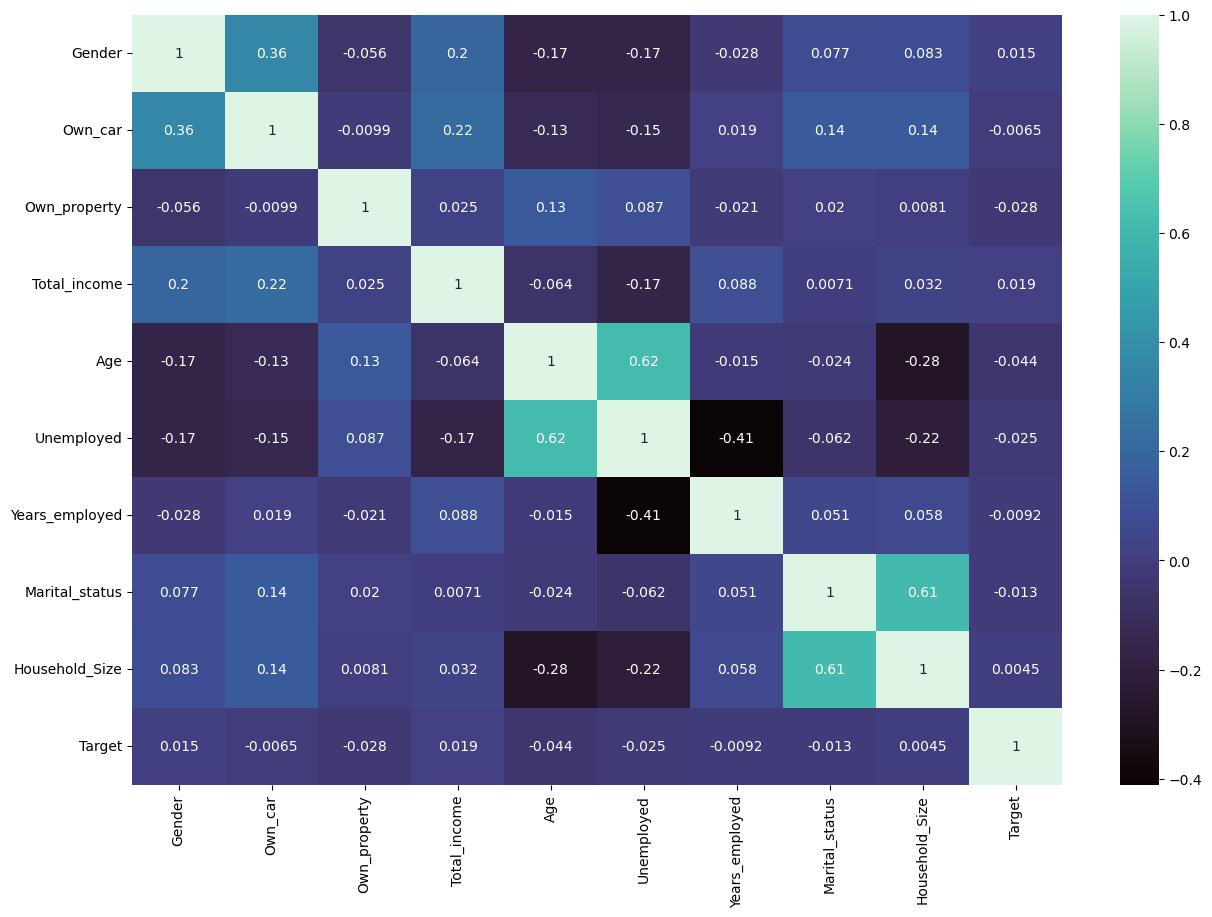

In [32]:
plt.figure(figsize=(15, 10))
corr=new_df.select_dtypes(include='number').corr()
sns.heatmap(corr,annot=True, cmap='mako')
plt.show();

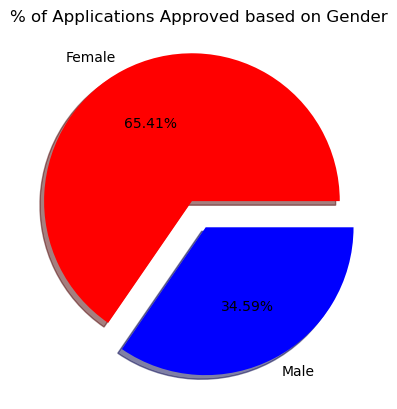

In [33]:
plt.pie(new_df[new_df['Target']==0]['Gender'].value_counts(), explode=[0.1,0.1],shadow =True, labels=['Female', 'Male'], autopct='%1.2f%%',colors=["red",'blue'])
plt.title('% of Applications Approved based on Gender')
plt.show()

Text(0.5, 1.0, 'Target distribution')

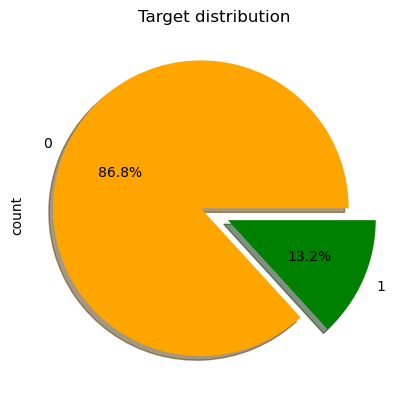

In [34]:
new_df['Target'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True, colors=['orange', 'green'],textprops = {'fontsize':10}).set_title("Target distribution")

In [35]:
colname=[]
for x in new_df.columns:
    if new_df[x].dtype=='object':
        colname.append(x)

In [36]:
le=LabelEncoder()
for x in colname:
    new_df[x]=le.fit_transform(new_df[x])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print('Feature', x)
    print('mapping', le_name_mapping)

Feature Income_type
mapping {'Pensioner': 0, 'Student': 1, 'Working': 2}
Feature Education_type
mapping {'Academic degree': 0, 'Higher education': 1, 'secondary': 2}
Feature Housing_type
mapping {'House / apartment': 0, 'With parents': 1}


In [37]:
X = new_df.iloc[:,0:-1]
Y = new_df.iloc[:,-1]  

In [38]:
scaler=StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [39]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=10)

In [40]:
classifier = LogisticRegression()
classifier.fit(X_train,Y_train)
Y_pred=classifier.predict(X_test)

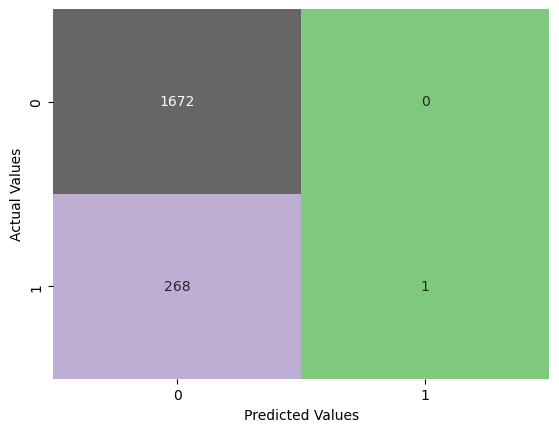

Classification report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1672
           1       1.00      0.00      0.01       269

    accuracy                           0.86      1941
   macro avg       0.93      0.50      0.47      1941
weighted avg       0.88      0.86      0.80      1941

Accuracy of the model:  0.8619268418341062


In [41]:
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='Accent')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))
acc=accuracy_score(Y_test,Y_pred)
print("Accuracy of the model: ",acc)

In [42]:
model_KNN=KNeighborsClassifier(n_neighbors=int(np.sqrt(len(X_train))), metric='euclidean')
model_KNN.fit(X_train,Y_train)
Y_pred=model_KNN.predict(X_test)

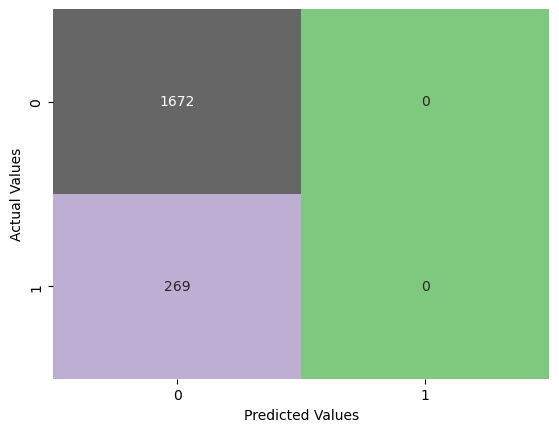

Classification report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1672
           1       0.00      0.00      0.00       269

    accuracy                           0.86      1941
   macro avg       0.43      0.50      0.46      1941
weighted avg       0.74      0.86      0.80      1941

Accuracy of the model:  0.8614116434827409


In [43]:
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='Accent')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))
acc=accuracy_score(Y_test,Y_pred)
print("Accuracy of the model: ",acc)

In [44]:
classifier = SVC(kernel='rbf',gamma=0.1,C=1)
classifier.fit(X_train,Y_train)
Y_pred = classifier.predict(X_test)

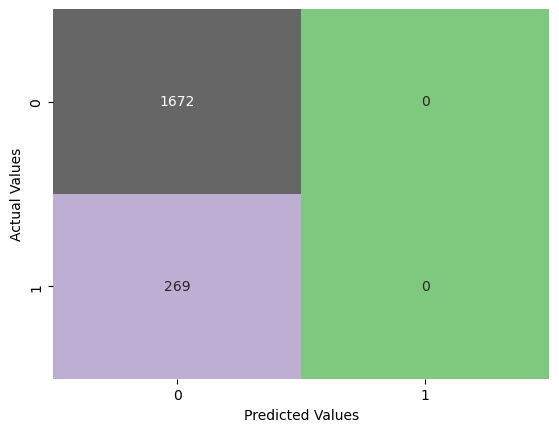

Classification report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1672
           1       0.00      0.00      0.00       269

    accuracy                           0.86      1941
   macro avg       0.43      0.50      0.46      1941
weighted avg       0.74      0.86      0.80      1941

Accuracy of the model:  0.8614116434827409


In [45]:
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='Accent')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))
acc=accuracy_score(Y_test,Y_pred)
print("Accuracy of the model: ",acc)

In [46]:
model_DecisionTree=DecisionTreeClassifier(criterion="gini",max_depth=7,random_state=10)
model_DecisionTree.fit(X_train,Y_train)
Y_pred=model_DecisionTree.predict(X_test)

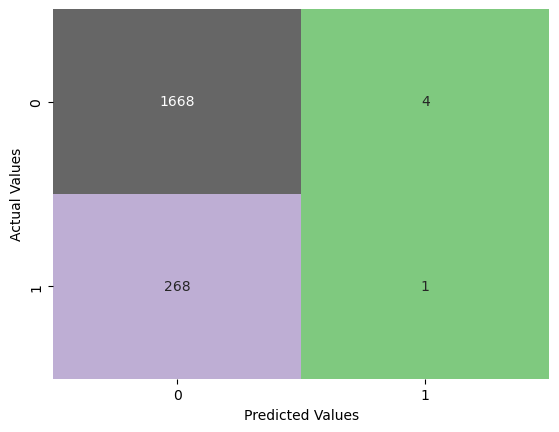

Classification report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1672
           1       0.20      0.00      0.01       269

    accuracy                           0.86      1941
   macro avg       0.53      0.50      0.47      1941
weighted avg       0.77      0.86      0.80      1941

Accuracy of the model:  0.859866048428645


In [47]:
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='Accent')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))
acc=accuracy_score(Y_test,Y_pred)
print("Accuracy of the model: ",acc)

In [48]:
model_RandomForest=RandomForestClassifier(n_estimators=50,random_state=10,n_jobs=-1, max_depth=7)
model_RandomForest.fit(X_train,Y_train)
Y_pred=model_RandomForest.predict(X_test)

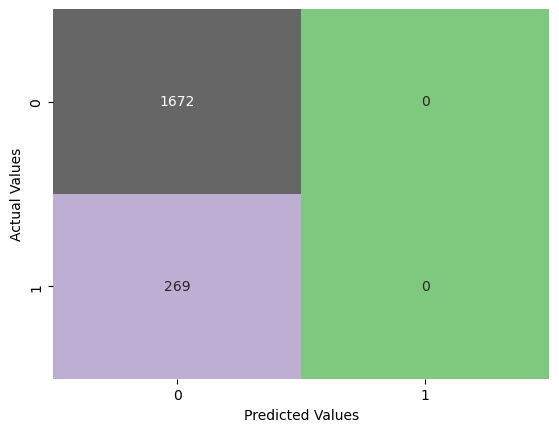

Classification report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1672
           1       0.00      0.00      0.00       269

    accuracy                           0.86      1941
   macro avg       0.43      0.50      0.46      1941
weighted avg       0.74      0.86      0.80      1941

Accuracy of the model:  0.8614116434827409


In [49]:
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='Accent')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))
acc=accuracy_score(Y_test,Y_pred)
print("Accuracy of the model: ",acc)

In [50]:
model_ExtraTrees = ExtraTreesClassifier(n_estimators=50,random_state=10)
model_ExtraTrees.fit(X_train,Y_train)
Y_pred = model_ExtraTrees.predict(X_test)

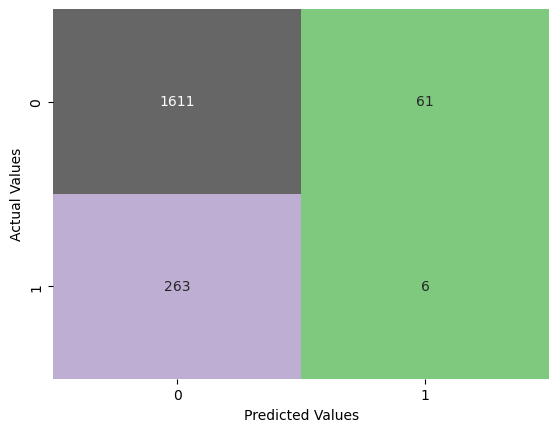

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1672
           1       0.09      0.02      0.04       269

    accuracy                           0.83      1941
   macro avg       0.47      0.49      0.47      1941
weighted avg       0.75      0.83      0.79      1941

Accuracy of the model:  0.8330757341576507


In [51]:
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='Accent')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))
acc=accuracy_score(Y_test,Y_pred)
print("Accuracy of the model: ",acc)

In [52]:
model_AdaBoost=AdaBoostClassifier(base_estimator= DecisionTreeClassifier(random_state=10), n_estimators=100, random_state=10)
model_AdaBoost.fit(X_train,Y_train)
Y_pred=model_AdaBoost.predict(X_test)

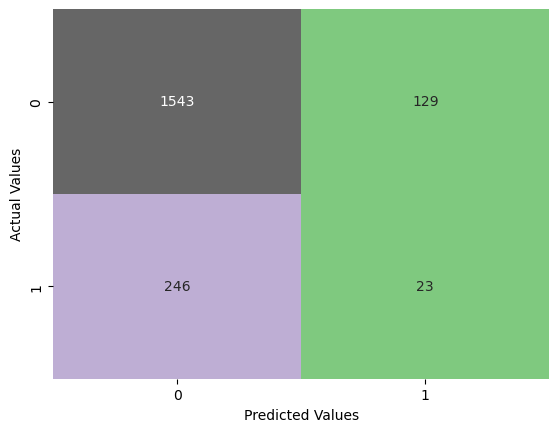

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1672
           1       0.15      0.09      0.11       269

    accuracy                           0.81      1941
   macro avg       0.51      0.50      0.50      1941
weighted avg       0.76      0.81      0.78      1941

Accuracy of the model:  0.8068006182380216


In [53]:
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='Accent')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))
acc=accuracy_score(Y_test,Y_pred)
print("Accuracy of the model: ",acc)

In [54]:
model_XGBoost=XGBClassifier(n_estimators=100, random_state=10)
model_XGBoost.fit(X_train,Y_train)
Y_pred=model_XGBoost.predict(X_test)

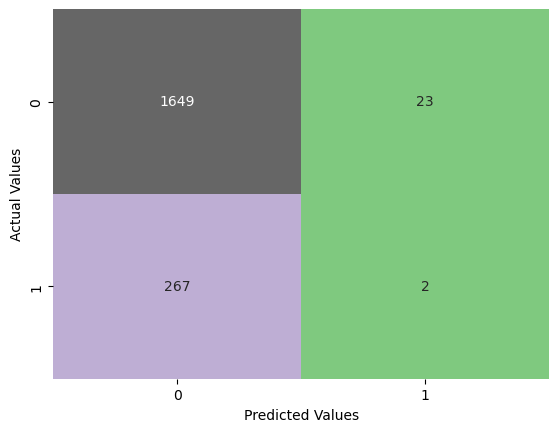

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1672
           1       0.08      0.01      0.01       269

    accuracy                           0.85      1941
   macro avg       0.47      0.50      0.47      1941
weighted avg       0.75      0.85      0.79      1941

Accuracy of the model:  0.85059247810407


In [55]:
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='Accent')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))
acc=accuracy_score(Y_test,Y_pred)
print("Accuracy of the model: ",acc)

In [56]:
data = {'Model': ['RandomForestClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier', 'XGBClassifier', 'LogisticRegression', 'SVC', 'KNeighborsClassifier'],
        'Accuracy': [accuracy_score(Y_test, model_RandomForest.predict(X_test)),
                     accuracy_score(Y_test, model_ExtraTrees.predict(X_test)),
                     accuracy_score(Y_test, model_AdaBoost.predict(X_test)),
                     accuracy_score(Y_test, model_XGBoost.predict(X_test)),
                     accuracy_score(Y_test, classifier.predict(X_test)),
                     accuracy_score(Y_test, classifier.predict(X_test)),
                     accuracy_score(Y_test, model_KNN.predict(X_test))]}
df = pd.DataFrame(data)
df['Accuracy'] = (df['Accuracy'] * 100).round(2).astype(str) + '%'
print(df)

                    Model Accuracy
0  RandomForestClassifier   86.14%
1    ExtraTreesClassifier   83.31%
2      AdaBoostClassifier   80.68%
3           XGBClassifier   85.06%
4      LogisticRegression   86.14%
5                     SVC   86.14%
6    KNeighborsClassifier   86.14%


In [57]:
X=new_df.values[:,:-1]
Y=new_df.values[:,-1]
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
X_train, X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=10)
print("Before OverSampling, counts of label '1': ", (sum(Y_train == 1)))
print("Before OverSampling, counts of label '0': ", (sum(Y_train == 0)))
sm = SMOTE(random_state = 10)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
print('After OverSampling, the shape of train_X: ', (X_train_res.shape))
print('After OverSampling, the shape of train_y: ', (Y_train_res.shape))
print("After OverSampling, counts of label '1': ", (sum(Y_train_res == 1)))
print("After OverSampling, counts of label '0': ", (sum(Y_train_res == 0)))

Before OverSampling, counts of label '1':  893
Before OverSampling, counts of label '0':  5897
After OverSampling, the shape of train_X:  (11794, 12)
After OverSampling, the shape of train_y:  (11794,)
After OverSampling, counts of label '1':  5897
After OverSampling, counts of label '0':  5897


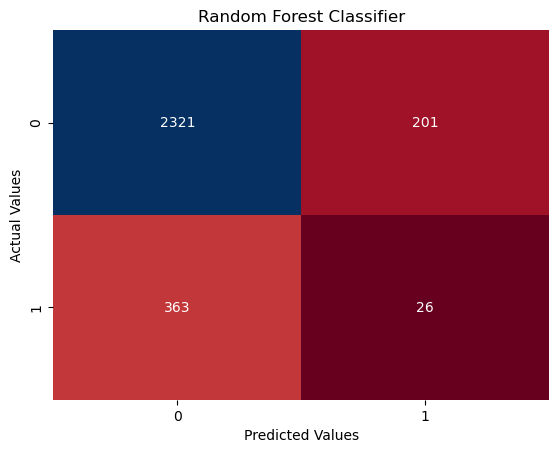

Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89      2522
         1.0       0.11      0.07      0.08       389

    accuracy                           0.81      2911
   macro avg       0.49      0.49      0.49      2911
weighted avg       0.76      0.81      0.78      2911



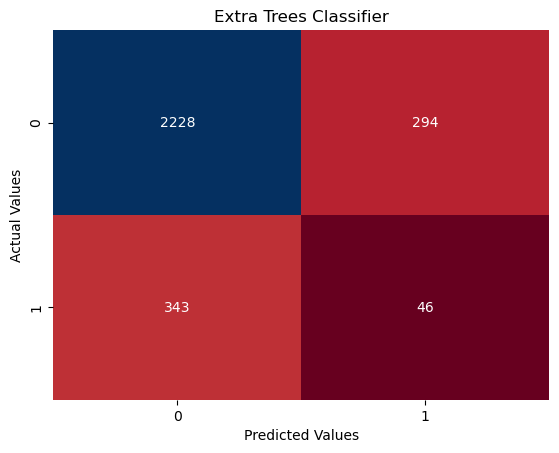

Classification report:
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      2522
         1.0       0.14      0.12      0.13       389

    accuracy                           0.78      2911
   macro avg       0.50      0.50      0.50      2911
weighted avg       0.77      0.78      0.77      2911



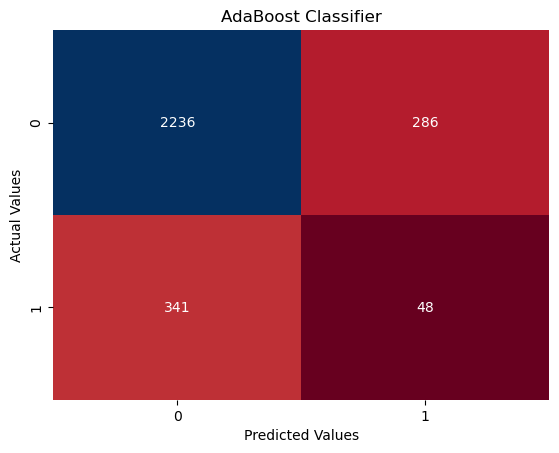

Classification report:
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      2522
         1.0       0.14      0.12      0.13       389

    accuracy                           0.78      2911
   macro avg       0.51      0.50      0.50      2911
weighted avg       0.77      0.78      0.78      2911



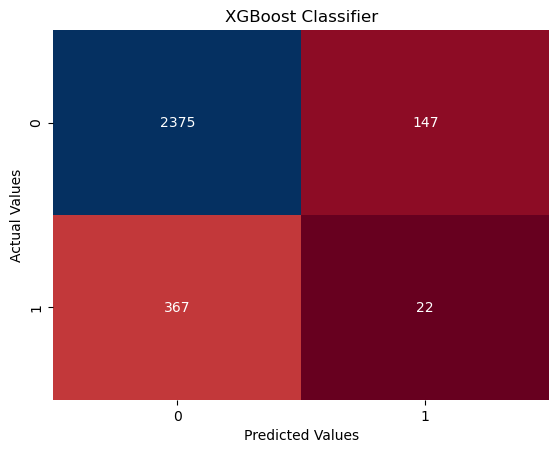

Classification report:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      2522
         1.0       0.13      0.06      0.08       389

    accuracy                           0.82      2911
   macro avg       0.50      0.50      0.49      2911
weighted avg       0.77      0.82      0.79      2911



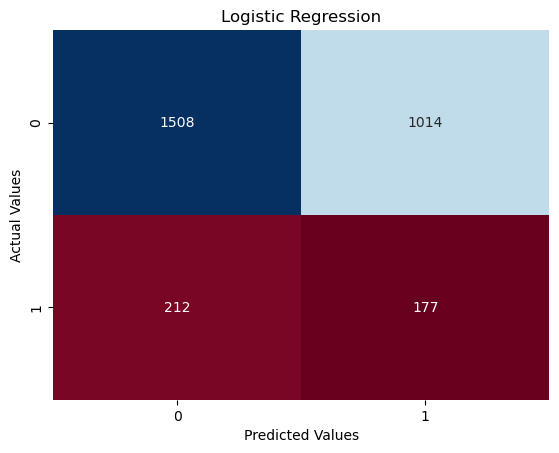

Classification report:
              precision    recall  f1-score   support

         0.0       0.88      0.60      0.71      2522
         1.0       0.15      0.46      0.22       389

    accuracy                           0.58      2911
   macro avg       0.51      0.53      0.47      2911
weighted avg       0.78      0.58      0.65      2911



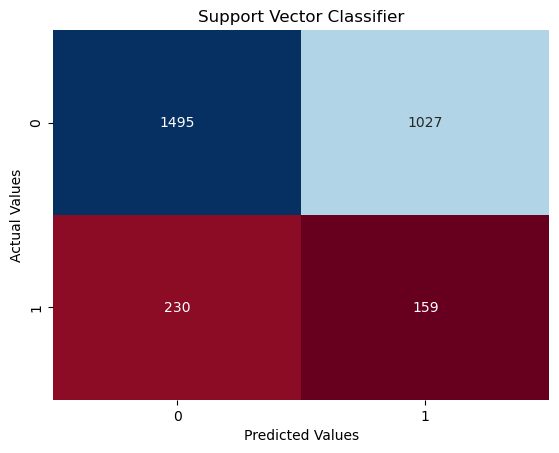

Classification report:
              precision    recall  f1-score   support

         0.0       0.87      0.59      0.70      2522
         1.0       0.13      0.41      0.20       389

    accuracy                           0.57      2911
   macro avg       0.50      0.50      0.45      2911
weighted avg       0.77      0.57      0.64      2911



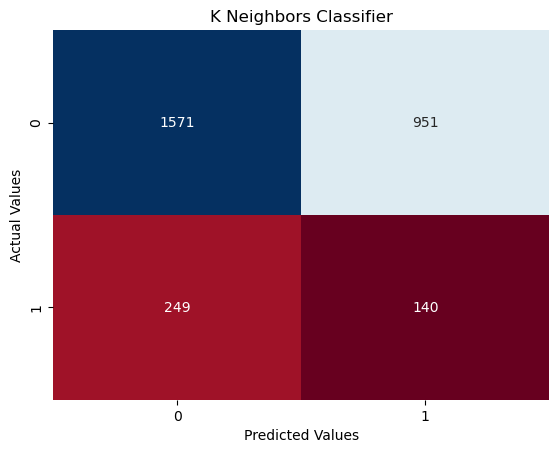

Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.62      0.72      2522
         1.0       0.13      0.36      0.19       389

    accuracy                           0.59      2911
   macro avg       0.50      0.49      0.46      2911
weighted avg       0.76      0.59      0.65      2911



In [58]:
model_RandomForest=RandomForestClassifier(n_estimators=100,random_state=10)
model_RandomForest.fit(X_train_res,Y_train_res)
Y_pred=model_RandomForest.predict(X_test)
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='RdBu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Random Forest Classifier')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))

model_ExtraTrees = ExtraTreesClassifier(n_estimators=50,random_state=10)
model_ExtraTrees.fit(X_train_res,Y_train_res)
Y_pred = model_ExtraTrees.predict(X_test)
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='RdBu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Extra Trees Classifier')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))

model_AdaBoost=AdaBoostClassifier(base_estimator= DecisionTreeClassifier(random_state=10), n_estimators=100, random_state=10)
model_AdaBoost.fit(X_train_res,Y_train_res)
Y_pred=model_AdaBoost.predict(X_test)
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='RdBu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('AdaBoost Classifier')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))

model_XGBoost=XGBClassifier(n_estimators=500, random_state=10)
model_XGBoost.fit(X_train_res,Y_train_res)
Y_pred=model_XGBoost.predict(X_test)
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='RdBu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('XGBoost Classifier')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))

classifier_Logistic=LogisticRegression()
classifier_Logistic.fit(X_train_res,Y_train_res)
Y_pred=classifier_Logistic.predict(X_test)
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='RdBu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Logistic Regression')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))

classifier_SVC = SVC(kernel='rbf',gamma=0.1,C=1)
classifier_SVC.fit(X_train_res,Y_train_res)
Y_pred = classifier_SVC.predict(X_test)
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='RdBu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Support Vector Classifier')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))

model_KNN=KNeighborsClassifier(n_neighbors=7, metric='euclidean')
model_KNN.fit(X_train_res,Y_train_res)
Y_pred=model_KNN.predict(X_test)
cfm=confusion_matrix(Y_test,Y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='RdBu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('K Neighbors Classifier')
plt.show()
print("Classification report:")
print(classification_report(Y_test,Y_pred))

In [59]:
data = {'Model': ['RandomForestClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier', 'XGBClassifier', 'LogisticRegression', 'SVC', 'KNeighborsClassifier'],
        'Accuracy': [accuracy_score(Y_test, model_RandomForest.predict(X_test)),
                     accuracy_score(Y_test, model_ExtraTrees.predict(X_test)),
                     accuracy_score(Y_test, model_AdaBoost.predict(X_test)),
                     accuracy_score(Y_test, model_XGBoost.predict(X_test)),
                     accuracy_score(Y_test, classifier.predict(X_test)),
                     accuracy_score(Y_test, classifier.predict(X_test)),
                     accuracy_score(Y_test, model_KNN.predict(X_test))]}
df = pd.DataFrame(data)
df['Accuracy'] = (df['Accuracy'] * 100).round(2).astype(str) + '%'
print(df)

                    Model Accuracy
0  RandomForestClassifier   80.63%
1    ExtraTreesClassifier   78.12%
2      AdaBoostClassifier   78.46%
3           XGBClassifier   82.34%
4      LogisticRegression   86.67%
5                     SVC   86.67%
6    KNeighborsClassifier   58.78%
